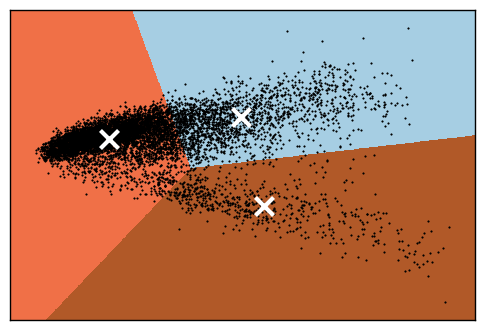

('For n_clusters =', 2, 'The average silhouette_score is :', 0.63124635455836819)


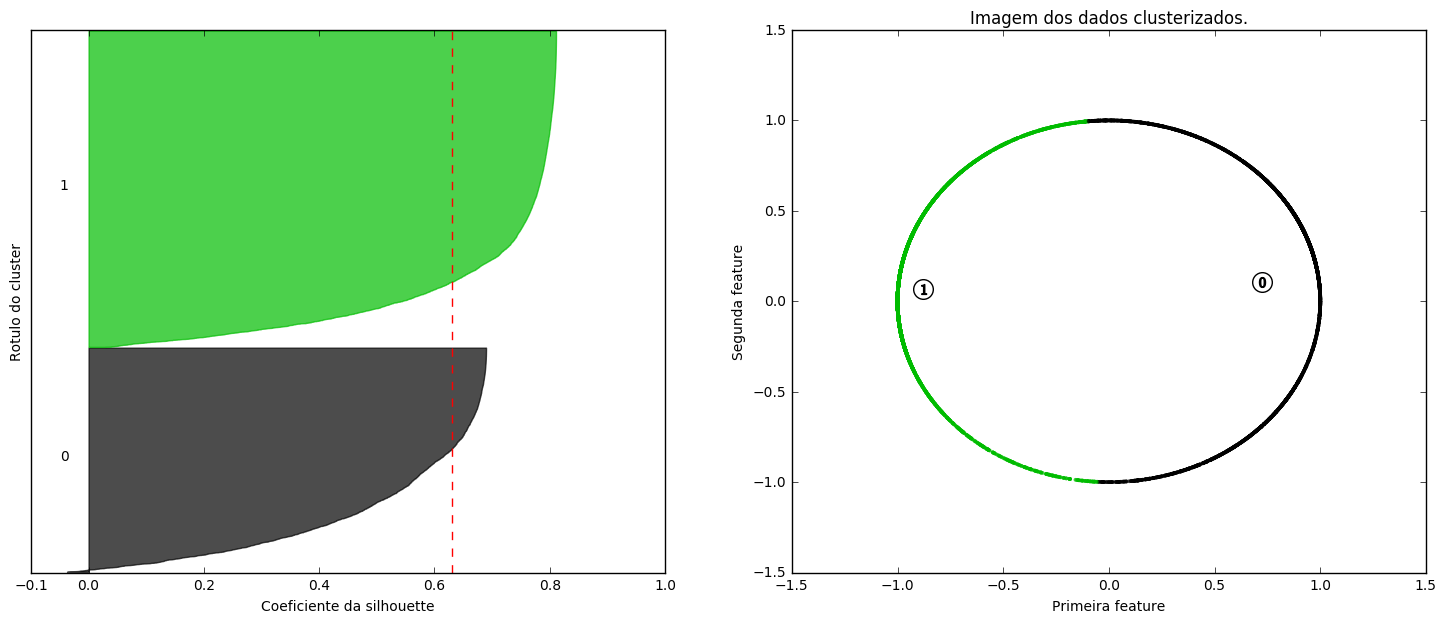

('For n_clusters =', 3, 'The average silhouette_score is :', 0.64449405523513292)


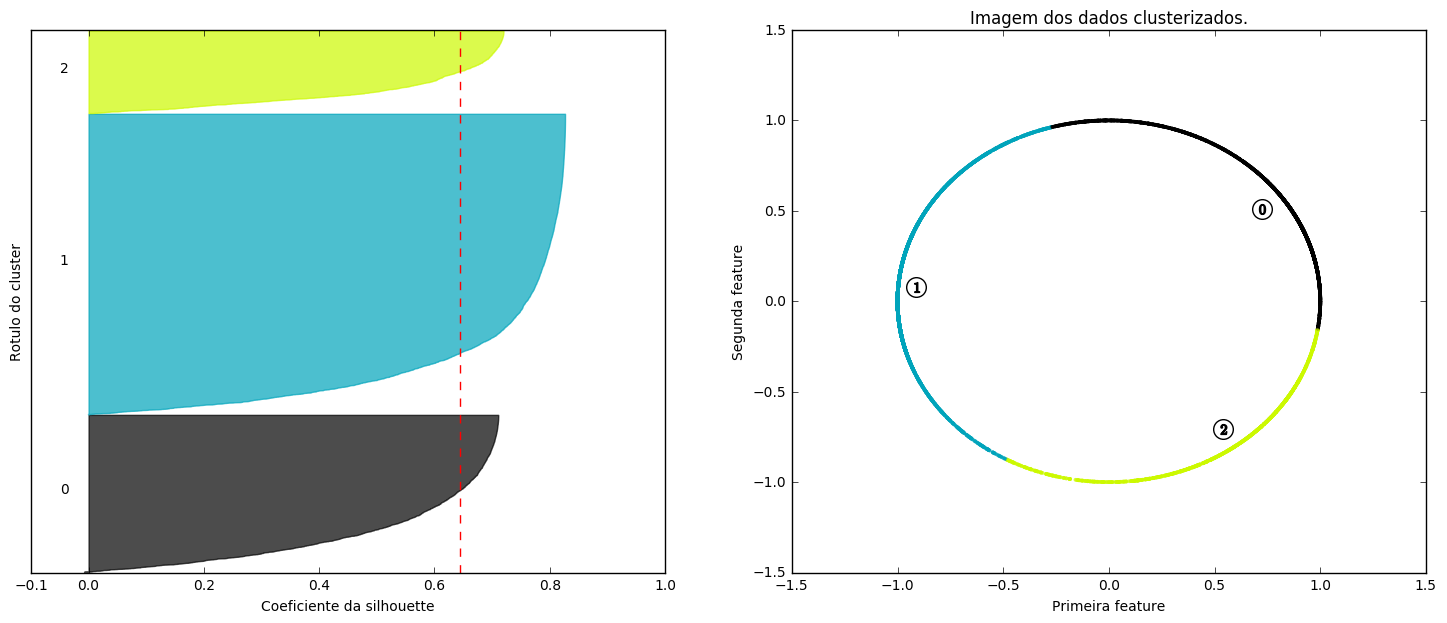

('For n_clusters =', 4, 'The average silhouette_score is :', 0.62209706609281334)


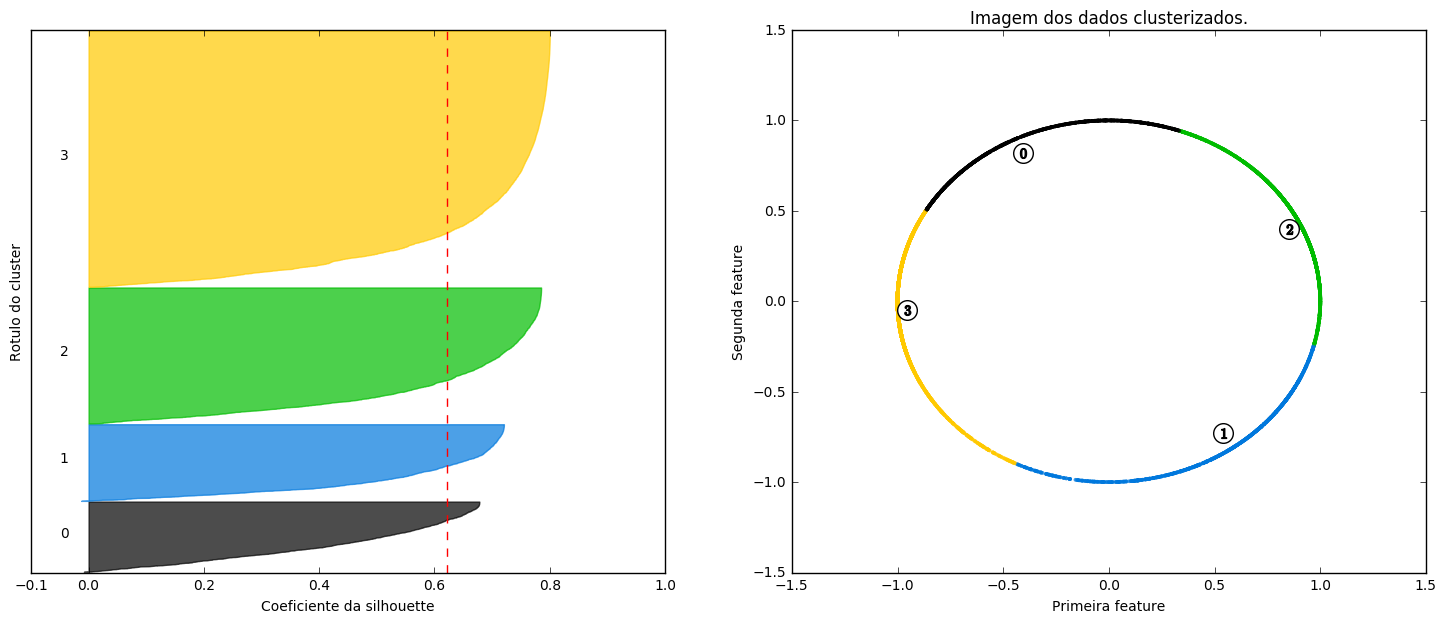

('For n_clusters =', 5, 'The average silhouette_score is :', 0.56617113568523614)


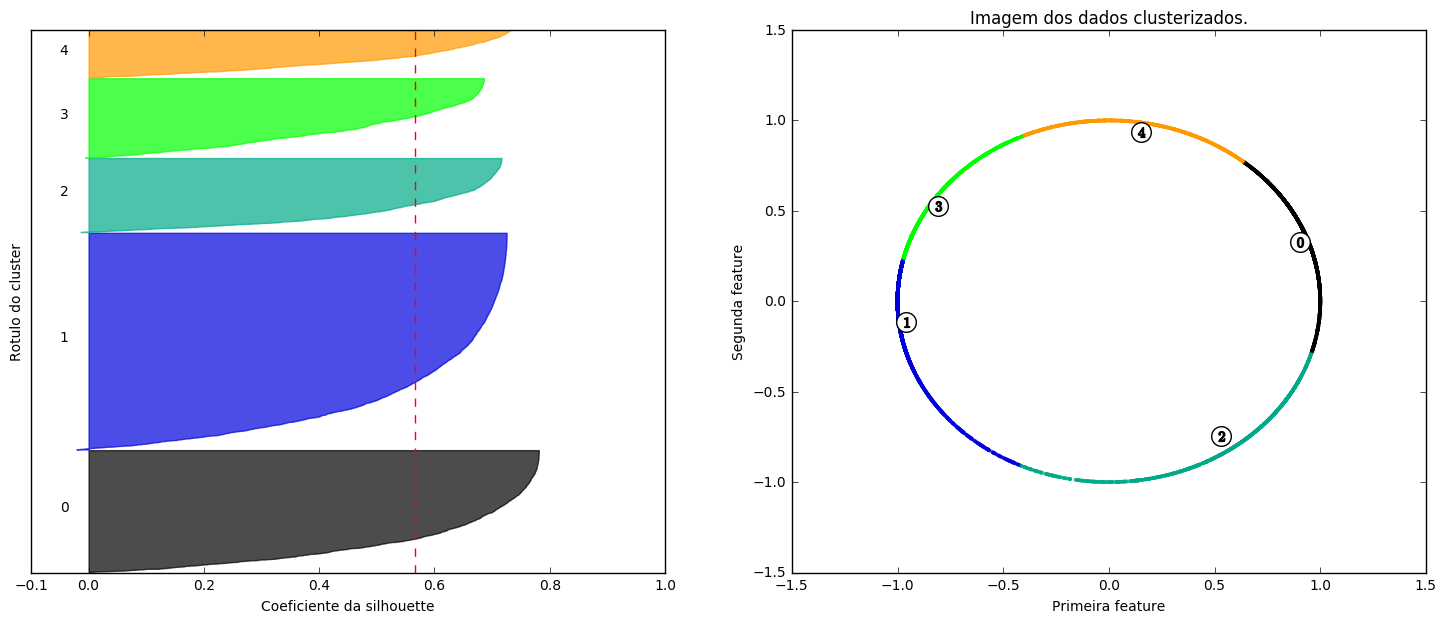

In [3]:
#Gera uma amostra de 8000 registros
#Este script tem o proposito de gerar imagens ilustrativas para compor o trabalho de conclusao
#Essas imagens vao auxiliar na explicacao dos conceitos

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3

from sklearn import metrics, preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import scale
from time import time

con = sqlite3.connect("database.sqlite")
df = pd.read_sql_query("""SELECT 
funded_amnt ,
funded_amnt_inv,
loan_amnt ,
cast (replace( term, ' months', '' ) as FLOAT) as term_float,
cast (replace( int_rate, '%', '' ) as FLOAT) as int_rate_float,
installment ,
annual_inc ,
dti ,
delinq_2yrs ,
inq_last_6mths ,
open_acc ,
pub_rec ,
revol_bal ,
total_acc ,
out_prncp ,
out_prncp_inv,
total_pymnt ,
total_pymnt_inv,
total_rec_prncp ,
total_rec_int ,
total_rec_late_fee ,
recoveries ,
collection_recovery_fee ,
last_pymnt_amnt from loan WHERE
funded_amnt IS NOT NULL AND
loan_amnt IS NOT NULL AND
term_float IS NOT NULL AND
int_rate_float IS NOT NULL AND
installment IS NOT NULL AND
emp_length IS NOT NULL AND
annual_inc IS NOT NULL AND
dti IS NOT NULL AND
delinq_2yrs IS NOT NULL AND
inq_last_6mths IS NOT NULL AND
open_acc IS NOT NULL AND
pub_rec IS NOT NULL AND
revol_bal IS NOT NULL AND
total_acc IS NOT NULL AND
out_prncp IS NOT NULL AND
total_pymnt IS NOT NULL AND
total_rec_prncp IS NOT NULL AND
total_rec_int IS NOT NULL AND
total_rec_late_fee IS NOT NULL AND
recoveries IS NOT NULL AND
collection_recovery_fee IS NOT NULL AND
last_pymnt_amnt IS NOT NULL limit 8000
""", con)


np.random.seed(42)

data = scale(df)

reduced_data = PCA(n_components=2).fit_transform(data)

#reduced_data = preprocessing.normalize(reduced_data)

kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
#plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
#          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

reduced_data = preprocessing.normalize(reduced_data)

X = reduced_data

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Coeficiente da silhouette")
    ax1.set_ylabel("Rotulo do cluster")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Imagem dos dados clusterizados.")
    ax2.set_xlabel("Primeira feature")
    ax2.set_ylabel("Segunda feature")


    plt.savefig('silhoute'+str(n_clusters)+'.png', bbox_inches='tight')
    plt.show()